In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import imageio
import mapclassify

# DATA
# load tree seed use results data from the BC Data Catalogue (data licence: Open Government Licence-British Columbia)
bc_forest = pd.read_csv("https://catalogue.data.gov.bc.ca/dataset/54ec827b-3b9a-4fea-8d9b-d8c006e5b9cc/resource/9e329a4d-1648-4c64-bb86-2cebba2517a2/download/bcregen.csv")
district_forest = pd.read_csv("https://catalogue.data.gov.bc.ca/dataset/54ec827b-3b9a-4fea-8d9b-d8c006e5b9cc/resource/a9f93154-5c3a-4752-bc34-cb3cbaff45c2/download/districtregen.csv")

#rename Year column
bc_forest = bc_forest.rename(columns={"Fiscal_Yr": "Year"})

bc_forest["planted_total"] = bc_forest["Planted_Natural_Stand_Superior_ha"] + bc_forest["Planted_Orchard_ha"] + bc_forest["Planted_Natural_Stand_NonSuperior_ha"]
bc_forest["reforest_total"] = bc_forest["planted_total"] + bc_forest["Natural_Regeneration_ha"]
bc_forest["ss_total"] = bc_forest["Planted_Natural_Stand_Superior_ha"] + bc_forest["Planted_Orchard_ha"]
bc_forest["ss_perc"] = round((bc_forest["ss_total"]/bc_forest["planted_total"])*100)

## restructuring the csv table for plotting
bc_long = pd.melt(bc_forest, id_vars = "Year", var_name = "seed", value_name = "hectares")

##remove _ha and underscores from names
bc_long["seed"] = bc_long["seed"].str.replace("_ha", "")
bc_long["seed"] = bc_long["seed"].str.replace("_", " ")

## creating data frame for total line
bc_total = bc_long.loc[bc_long["seed"] == "reforest total"].copy()
bc_total["area"] = round(bc_total["hectares"]/1000, ndigits=0)

## creating data frame for seed stacked geom
bc_seed = bc_long.loc[~bc_long["seed"].isin(["reforest total", "planted total", "ss total", "ss perc"])].copy()
bc_total["area"] = round(bc_total["hectares"]/1000, ndigits=0)

## arranging the order of the species to be plotted
seed_order = ["Planted Orchard", "Planted Natural Stand Superior",
                "Planted Natural Stand NonSuperior", "Natural Regeneration"]

## reordering the variables for plotting
bc_seed["seed"] = pd.Categorical(bc_seed["seed"], categories=seed_order, ordered=True)

## matching colour name with variable names
## colours and HEX codes from http://colorbrewer2.org/
pal = {"Planted Orchard": "#99cc00", "Planted Natural Stand Superior": "#339966", "Planted Natural Stand NonSuperior": "#ccffcc", "Natural Regeneration": "#ffff99"}



In [2]:
# !pip install mapclassify



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
bc_forest.describe()


,Year,Natural_Regeneration_ha,Planted_Natural_Stand_Superior_ha,Planted_Orchard_ha,Planted_Natural_Stand_NonSuperior_ha,planted_total,reforest_total,ss_total,ss_perc
count,33.00000,33.000000,33.000000,33.000000,33.00000,33.000000,33.000000,33.000000,33.000000
mean,2003.00000,41879.684848,8016.161818,57309.874545,113719.29697,179045.333333,220925.018182,65326.036364,36.575758
std,9.66954,17202.973101,6460.625881,39095.140596,47304.08579,19321.422405,22417.595492,44792.240510,24.367025
min,1987.00000,8661.000000,100.790000,99.370000,52217.83000,145318.540000,183811.170000,534.970000,0.000000
25%,1995.00000,30293.800000,2006.400000,24727.120000,69792.56000,164132.810000,206248.400000,26919.660000,13.000000
50%,2003.00000,44224.900000,5997.670000,56652.200000,99252.12000,181182.680000,216034.380000,62649.870000,40.000000
75%,2011.00000,50271.600000,14192.500000,88488.110000,153542.47000,193358.470000,237583.370000,101375.630000,62.000000
max,2019.00000,79652.700000,18820.080000,118019.140000,209526.37000,214850.980000,275004.910000,128964.850000,71.000000


In [14]:
bc_forest.head()

,Year,Natural_Regeneration_ha,Planted_Natural_Stand_Superior_ha,Planted_Orchard_ha,Planted_Natural_Stand_NonSuperior_ha,planted_total,reforest_total,ss_total,ss_perc
0,1987,49767.3,100.79,434.18,151520.43,152055.40,201822.70,534.97,0.0
1,1988,67234.1,455.75,99.37,153542.47,154097.59,221331.69,555.12,0.0
2,1989,63697.4,260.64,1200.22,172037.65,173498.51,237195.91,1460.86,1.0
3,1990,48259.8,636.90,2125.87,209526.37,212289.14,260548.94,2762.77,1.0
4,1991,50085.1,1362.55,4271.94,189649.94,195284.43,245369.53,5634.49,3.0


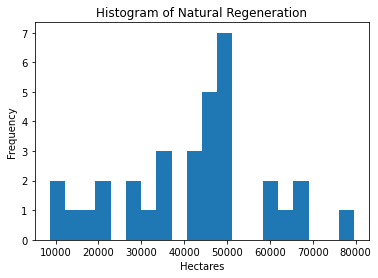

In [10]:
plt.hist(bc_forest["Natural_Regeneration_ha"], bins=20)
plt.xlabel("Hectares")
plt.ylabel("Frequency")
plt.title("Histogram of Natural Regeneration")
plt.show()


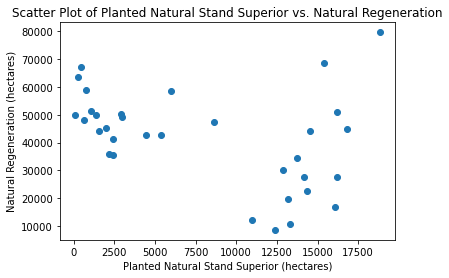

In [11]:
plt.scatter(bc_forest["Planted_Natural_Stand_Superior_ha"], bc_forest["Natural_Regeneration_ha"])
plt.xlabel("Planted Natural Stand Superior (hectares)")
plt.ylabel("Natural Regeneration (hectares)")
plt.title("Scatter Plot of Planted Natural Stand Superior vs. Natural Regeneration")
plt.show()


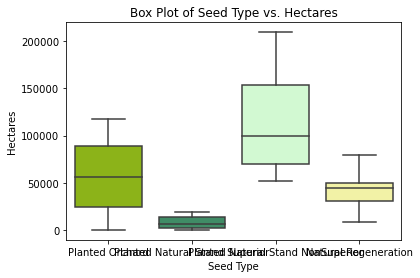

In [12]:
sns.boxplot(x="seed", y="hectares", data=bc_seed, palette=pal)
plt.xlabel("Seed Type")
plt.ylabel("Hectares")
plt.title("Box Plot of Seed Type vs. Hectares")
plt.show()


In [22]:
bc_forest = bc_forest.reset_index()




In [24]:
bc_forest.columns

Index(['Year', 'Natural_Regeneration_ha', 'Planted_Natural_Stand_Superior_ha',
       'Planted_Orchard_ha', 'Planted_Natural_Stand_NonSuperior_ha',
       'planted_total', 'reforest_total', 'ss_total', 'ss_perc'],
      dtype='object')

TIME SERIES ANALYSIS

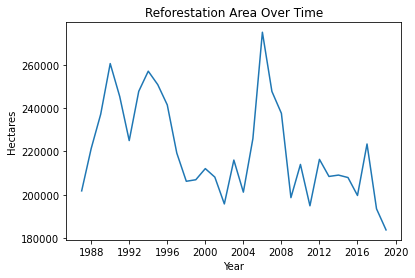

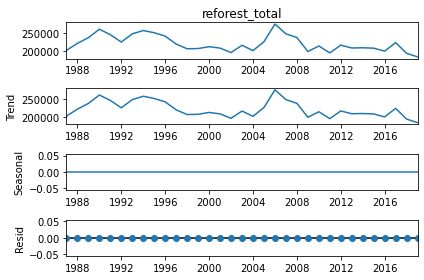

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# convert the "Year" column to a datetime format
bc_forest["Year"] = pd.to_datetime(bc_forest["Year"], format="%Y")

# set the "Year" column as the index of the dataframe
bc_forest.set_index("Year", inplace=True)

# set figure size
sns.set(rc={'figure.figsize':(10,6)})

# plot the time series data for the "reforest_total" column
plt.plot(bc_forest["reforest_total"])
plt.xlabel("Year")
plt.ylabel("Hectares")
plt.title("Reforestation Area Over Time")
plt.show()

# perform seasonal decomposition on the "reforest_total" column
decomp = seasonal_decompose(bc_forest["reforest_total"], model="additive", period=1)

# plot the seasonal decomposition results
decomp.plot()
plt.xlabel("Year")
plt.suptitle("Seasonal Decomposition of Reforestation Area")
plt.show()


CORRELATION ANALYSIS

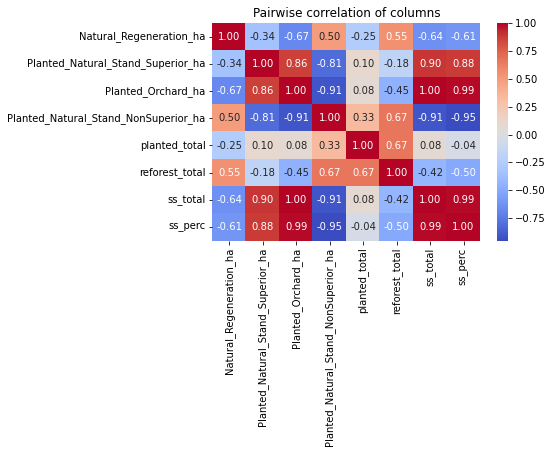

In [ ]:
# Compute pairwise correlation of columns
corr_matrix = bc_forest.corr()

# Plot heatmap of correlation matrix
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Pairwise correlation of columns")
plt.show()


You can interpret the results of the correlation analysis by looking at the values of the correlation coefficients. A coefficient of 1 represents a perfect positive correlation, -1 represents a perfect negative correlation, and 0 represents no correlation. Coefficients between -1 and 1 represent varying degrees of correlation strength.

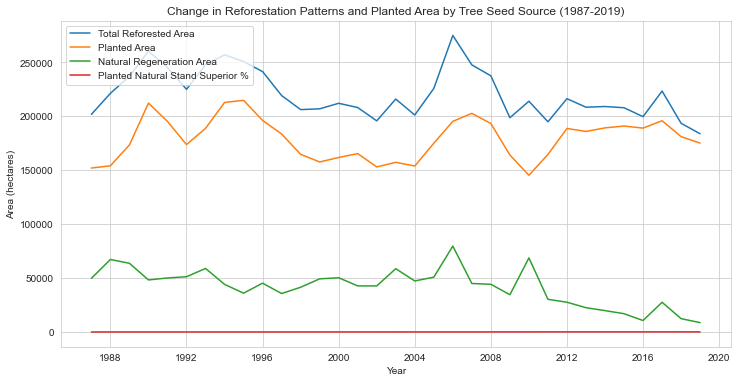

In [ ]:
# reset index of the bc_forest DataFrame
bc_forest.reset_index(inplace=True)

# create a subset of the bc_forest data containing only the columns we need for analysis
bc_forest_subset = bc_forest[['Year', 'planted_total', 'Natural_Regeneration_ha', 'reforest_total', 'ss_perc']]

# create a line plot showing the change in reforestation patterns and the change in area of forest planted by tree seed source from 1987 to 2019
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(data=bc_forest_subset, x='Year', y='reforest_total', ax=ax, label='Total Reforested Area')
sns.lineplot(data=bc_forest_subset, x='Year', y='planted_total', ax=ax, label='Planted Area')
sns.lineplot(data=bc_forest_subset, x='Year', y='Natural_Regeneration_ha', ax=ax, label='Natural Regeneration Area')
sns.lineplot(data=bc_forest_subset, x='Year', y='ss_perc', ax=ax, label='Planted Natural Stand Superior %')

ax.set_title('Change in Reforestation Patterns and Planted Area by Tree Seed Source (1987-2019)')
ax.set_ylabel('Area (hectares)')
ax.set_xlabel('Year')
plt.legend(loc='upper left')
plt.show()


- The chart above displays the change in reforestation patterns—planted versus natural regeneration—and the change in area of forest planted by tree seed source from 1987 to 2019.<br>
- After a disturbance by forest fire, forest pest or forest harvest, reforestation occurs by natural regeneration, meaning from roots or seed, or by planting. Seed used for planting may be from one or more genetic sources: orchard, natural stand superior provenance, and natural stand non-superior provenance.
- Both orchard and natural stand superior provenance seed sources have a known level of improvement based on extensive forest genetic adaptation research trials and tree breeding for the selection of desired traits—such as growth, pest resistance and wood density.
